## Table of Contents
1. Data preparation
2. Exploratory data analysis
3. Model training
4. Conclusion

### Analysis of Exercise and Fitness Metrics and Exercise Intensity prediction
Engaging in regular physical activity is essential for individuals to maintain optimal health and well-being. 
The benefits of physical activity extend far beyond just physical fitness. They encompass mental, emotional, and 
social aspects of our lives, making it an integral part of human existence. 
Likewise, the topic of health is one of the most critical subjects for humanity to prioritize due to its profound 
impact on individuals and society as a whole.

### Gathering individual health data when working out at a gym is crucial for several reasons

Firstly, tracking personal health data allows individuals to monitor their progress and make informed decisions about their fitness goals. By collecting data, individuals can tailor their workout routines, adjust intensity levels, and make necessary modifications to achieve desired results effectively.
Secondly, individual health data provides insights into overall health and potential risk factors. By regularly monitoring metrics such as heart rate variability, resting heart rate, and blood pressure, individuals can identify any abnormalities or potential health issues.

Collecting health data promotes accountability and motivation. When individuals track their progress and see tangible results, it serves as a powerful motivator to continue their fitness journey.

Lastly, the aggregation of health data from gym-goers can contribute to research and the development of evidence-based practices. With consent and proper anonymization, aggregated health data can be used to identify trends, patterns, and correlations that can benefit the larger population.

This project is mostly EDA practice - we take a closer look at the data and look for patterns in it. We will also do a little data preparation step since it's a good practice overall and try to predict Exercise Intensity as our ML task, but there won't be any meaningful tuning and I don't expect good results from it. (Don't mind sklearn pipeline, I'm just probing it's possibilities)

## Description of columns:

- ID - A unique identifier for each sample in the dataset.
- Exercise - The type of exercise performed during the session
- Calories Burn - The estimated number of calories burned during the exercise session.
- Dream Weight - The desired weight of the individual.
- Actual Weight - The measured weight of the individual, including natural variation.
- Age - The age of the individual performing the exercise.
- Gender - The gender of the individual (Male or Female)
- Duration - The duration of each exercise session in minutes.
- Heart Rate - The average heart rate during the exercise session.
- BMI - The body mass index of the individual, indicating body composition.
- Weather Conditions
- Exercise Intensity

## Data preparation
Let's start from loading all necessary libraries and dataframe:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import joblib

# RandomState
state = np.random.RandomState(12345)

In [2]:
df = pd.read_csv('dataset.csv')

Let's peek into our data:

In [3]:
df.head()

,ID,Exercise,Calories Burn,Dream Weight,Actual Weight,Age,Gender,Duration,Heart Rate,BMI,Weather Conditions,Exercise Intensity
0,1,Exercise 2,286.959851,91.892531,96.301115,45,Male,37,170,29.426275,Rainy,5
1,2,Exercise 7,343.453036,64.165097,61.104668,25,Male,43,142,21.286346,Rainy,5
2,3,Exercise 4,261.223465,70.846224,71.766724,20,Male,20,148,27.899592,Cloudy,4
3,4,Exercise 5,127.183858,79.477008,82.984456,33,Male,39,170,33.729552,Sunny,10
4,5,Exercise 10,416.318374,89.960226,85.643174,29,Female,34,118,23.286113,Cloudy,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864 entries, 0 to 3863
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  3864 non-null   int64  
 1   Exercise            3864 non-null   object 
 2   Calories Burn       3864 non-null   float64
 3   Dream Weight        3864 non-null   float64
 4   Actual Weight       3864 non-null   float64
 5   Age                 3864 non-null   int64  
 6   Gender              3864 non-null   object 
 7   Duration            3864 non-null   int64  
 8   Heart Rate          3864 non-null   int64  
 9   BMI                 3864 non-null   float64
 10  Weather Conditions  3864 non-null   object 
 11  Exercise Intensity  3864 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 362.4+ KB


Data is well interpretable.

Let's remove the ID column, stock pandas indexing is enough for us and proceed further:

In [5]:
df.drop('ID', axis=1, inplace=True)

And let's change 'Exercise' column to int:

In [6]:
df['Exercise'] = df['Exercise'].map(lambda x: ''.join([i for i in x if i.isdigit()]))

And give some columns more suitable dtypes:

In [7]:
ints = [
    'Exercise', 
    'Age', 
    'Duration', 
    'Heart Rate', 
    'Exercise Intensity'
]

categories = [
    'Gender', 
    'Weather Conditions'
]

for col in ints:
    df[col] = df[col].astype('int16')

for col in categories:
    df[col] = df[col].astype('category')

As we can see data may greatly vary from one individual to another.

P.S. It's always pleasant to work with clean and prepared data. Synthetic origin is too obvious.

## Exploratory data analysis

Let's start with checking descriptive statistics:

In [8]:
df.describe()

,Exercise,Calories Burn,Dream Weight,Actual Weight,Age,Duration,Heart Rate,BMI,Exercise Intensity
count,3864.000000,3864.000000,3864.000000,3864.000000,3864.000000,3864.000000,3864.000000,3864.000000,3864.000000
mean,5.549172,301.861806,75.139263,75.188440,39.621118,40.190994,139.777950,26.801977,5.457298
std,2.880422,115.828604,14.545824,14.845511,12.521721,11.765957,23.447528,4.746745,2.850896
min,1.000000,100.009403,50.001984,45.783747,18.000000,20.000000,100.000000,18.500014,1.000000
25%,3.000000,202.168837,62.373585,62.476906,29.000000,30.000000,119.000000,22.686774,3.000000
50%,6.000000,299.742508,75.522136,75.544407,40.000000,40.000000,140.000000,26.861656,5.000000
75%,8.000000,404.143688,87.707989,88.105767,51.000000,51.000000,160.000000,30.950380,8.000000
max,10.000000,499.859262,99.985355,104.309600,60.000000,60.000000,180.000000,34.996639,10.000000


`Calories Burn`, `Duration` and `Age` differ greatly among respondents.

Now let's check our data distributions:

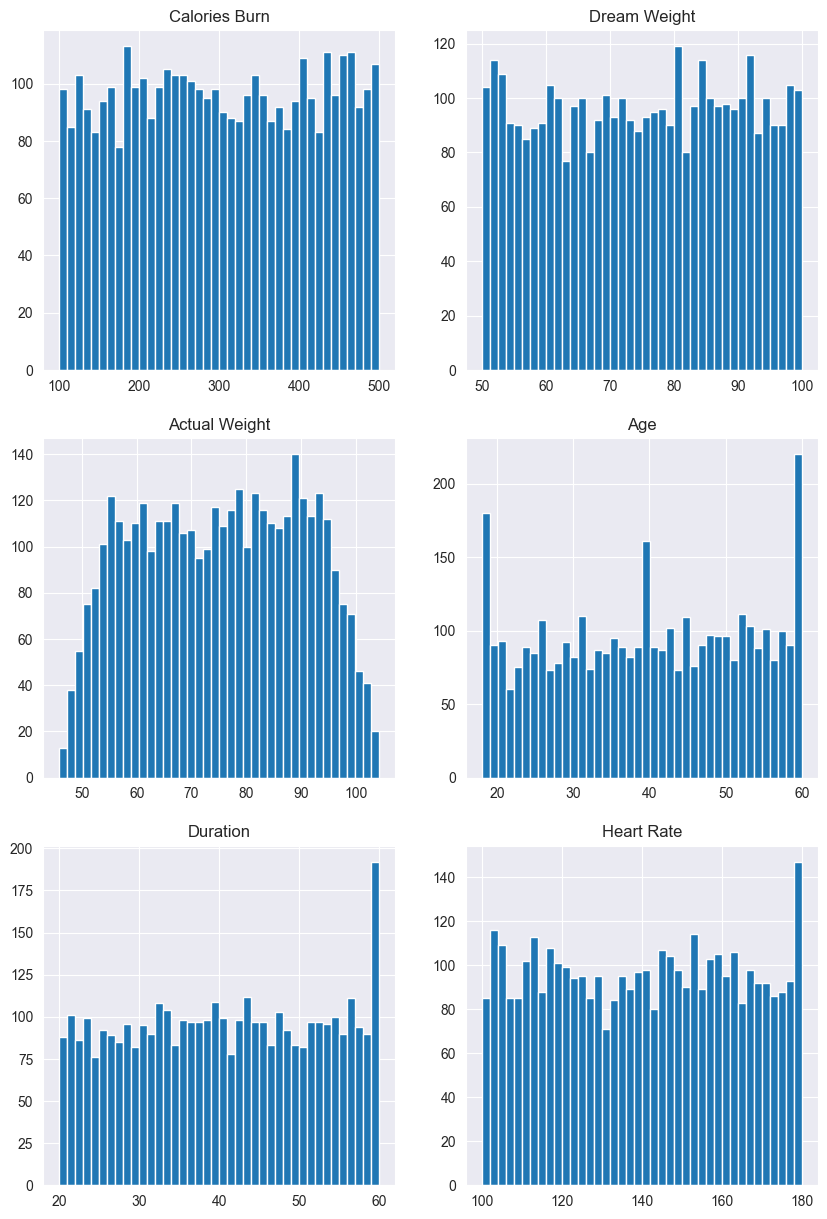

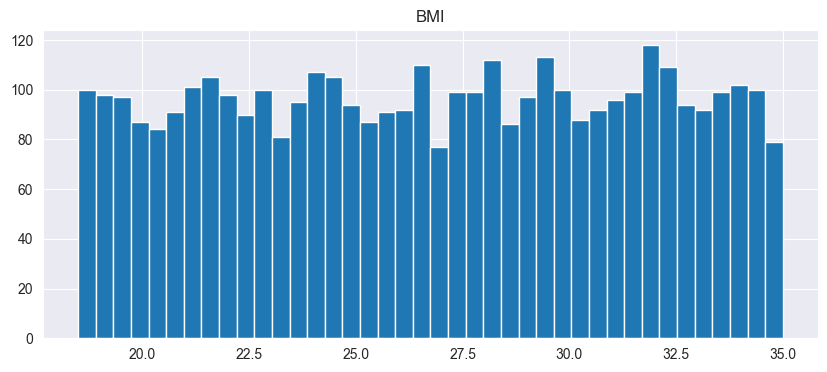

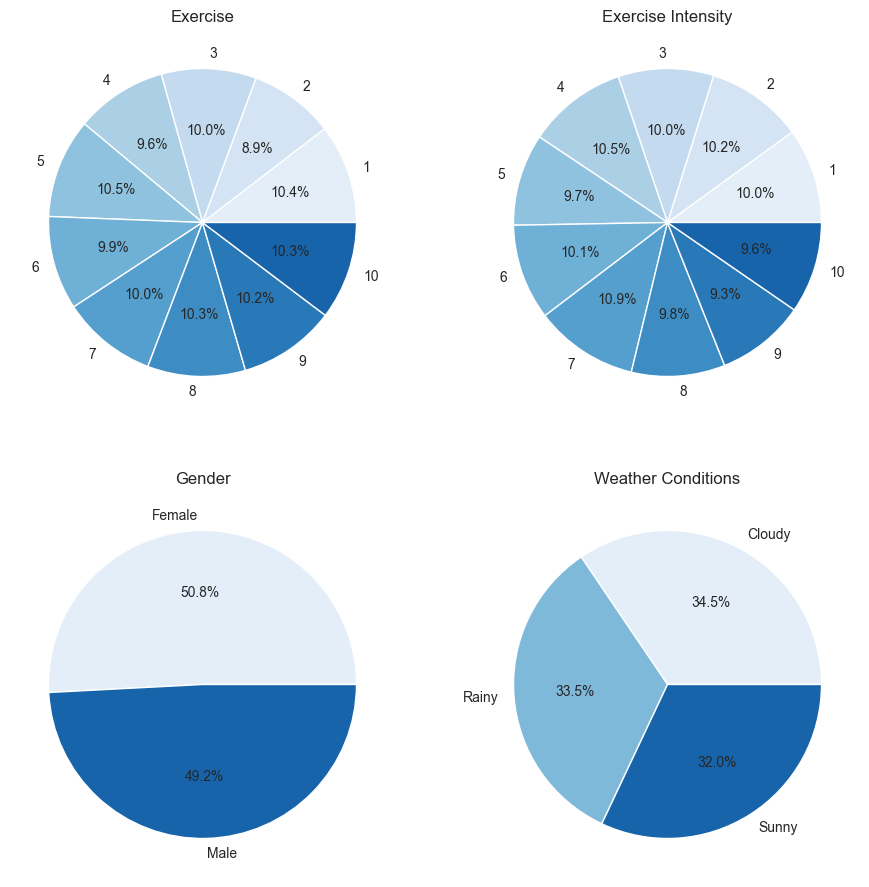

In [9]:
_, axs = plt.subplots(3, 2, figsize=[10,15])
cols = [
    (axs[0,0], 'Calories Burn'),
    (axs[0,1], 'Dream Weight'),
    (axs[1,0], 'Actual Weight'),
    (axs[1,1], 'Age'),
    (axs[2,0], 'Duration'),
    (axs[2,1], 'Heart Rate'),
]
for i, (ax, col) in enumerate(cols):
    ax.set(title=col)
    ax.hist(df[col], bins=40)
plt.figure(figsize=[10,4])
plt.title('BMI')
plt.hist(df['BMI'], bins=40)

_, axs = plt.subplots(2, 2, figsize=[11,11])
cols = [
    (axs[0,0], 'Exercise'),
    (axs[0,1], 'Exercise Intensity'),
    (axs[1,0], 'Gender'),
    (axs[1,1], 'Weather Conditions')
]

cmap = plt.get_cmap('Blues')

for i, (ax, col) in enumerate(cols):
    ax.set(title=col)
    values = df[col].value_counts().sort_index()
    ind = values.index
    colors = list(cmap(np.linspace(0.1, 0.8, len(values))))
    ax.pie(
        values, 
        labels=ind, 
        autopct='%.1f%%', 
        colors=colors
    )

The difference between the most common `Exercise` group (fifth one) and the rarest (second) is only 50.

`Actual Weight` is kinda normally distributed, that's nice.

If the data is random sample, then seeing so many people over 50 exercising is a good sign. Engaging in activities that promote physical health and maintaining a healthy lifestyle can indeed reduce the risk of developing certain age-related diseases.

Strange to see almost the same number of `Duration == 20` and `Duration == 60`. It's hard to imagine that the same number of people come to the gym for 20 and 60 minute workouts, given that 60 minute workouts are considered optimal and are more popular. (Author really should consider changing this distribution to exponential)

Men and women were almost equally divided among the respondents. And also people don't skip their workouts or rainy days, expected less entries on rainy days.

P.S. Let's try to guess from which region the statistics could've been collected (if weren't synthetic). Personally thinking it could be UK/Ireland/Pacific Northwest, USA (including Seattle)/Belgium/Netherlands/Germany/Vancouver, Canada/Scotland

Let's continue with linear correlation matrix:

<Axes: >

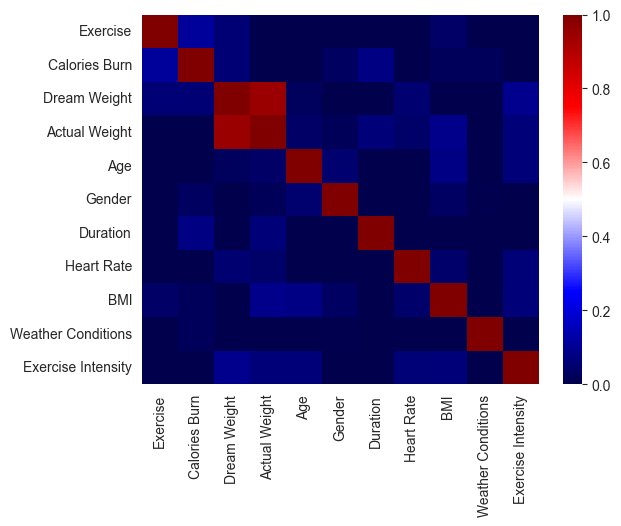

In [10]:
cols = [
    'Calories Burn', 
    'Dream Weight',
    'Actual Weight',
    'Age',
    'Duration',
    'Heart Rate',
    'BMI',
    'Exercise Intensity'
]

sns.heatmap(df.phik_matrix(interval_cols=cols), cmap ='seismic')

As we can see, columns don't correlate with each other, except for `Actual Weight`/`Dream Weight` pair. It could be due to people relying on their own weight, when envisioning their weight preferences.

Now it's time for a little feature engineering. Let's add a Weight Difference column with `Actual Weight` - `Dream Weight` module values and a `Gain` column describing whatever respondent wants to gain some weight or lose it:

In [11]:
def gain(x):
    if x < 0:
        return 'Gain'
    else: return 'Lose'

df['Weight Difference'] = df['Actual Weight'] - df['Dream Weight']
df['Gain'] = df['Weight Difference'].apply(gain).astype('category')
df['Weight Difference'] = abs(df['Weight Difference'])

Now let's check new columns distributions:

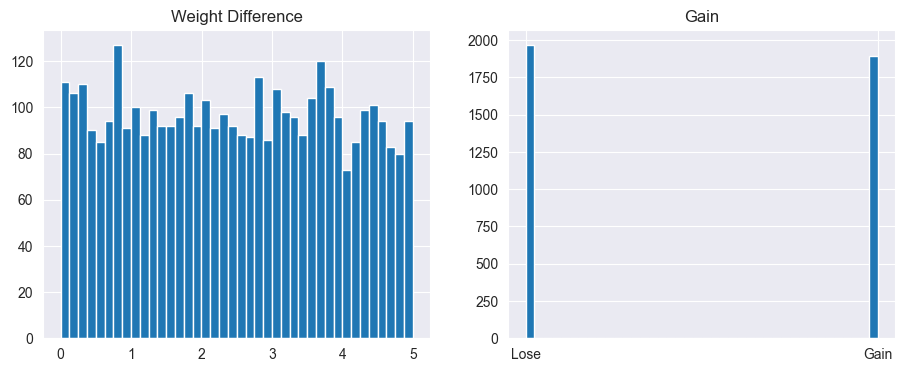

In [12]:
_, axs = plt.subplots(1, 2, figsize=[11,4])
cols = [
    (axs[0], 'Weight Difference'),
    (axs[1], 'Gain')
]
for i, (ax, col) in enumerate(cols):
    ax.set(title=col)
    ax.hist(df[col], bins=40)

`Weight Difference` is kinda chaotic and `Gain` is almost equal, with little preference for weight loss.

Let's see if there are weight gain/loss preferences among men and women:

array([<Axes: ylabel='Gain'>, <Axes: ylabel='Lose'>], dtype=object)

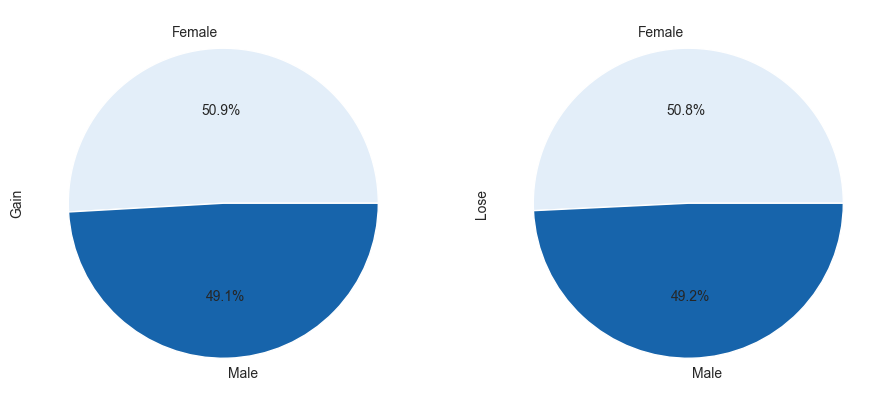

In [13]:
colors = cmap(np.linspace(0.1, 0.8, 2))
df.pivot_table(
    columns='Gain',
    index='Gender',
    values='Exercise',
    aggfunc='count'
).plot(
    kind='pie', 
    autopct='%.1f%%',
    colors=colors, 
    subplots=True, 
    figsize=[11,11], 
    legend=False
)

Almost equal.

Continue with median actual/dream weights:

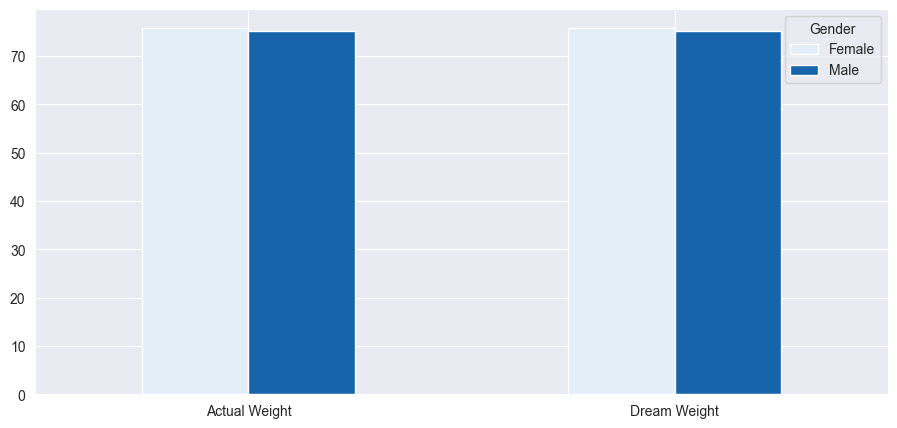

In [14]:
colors = cmap(np.linspace(0.1, 0.8, 2))
df.pivot_table(
    columns='Gender',
    values=['Actual Weight', 'Dream Weight'],
    aggfunc='median'
).plot(
    kind='bar', 
    figsize=[11,5], 
    rot=0, 
    color=colors
);

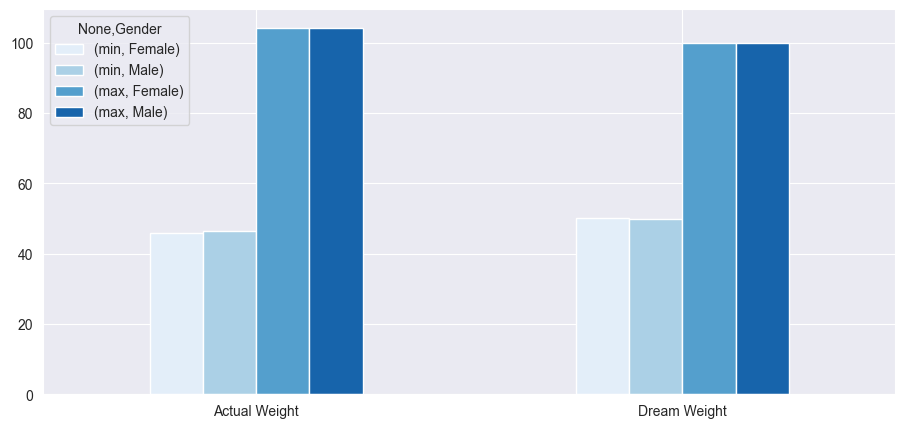

In [15]:
colors = cmap(np.linspace(0.1, 0.8, 4))
df.pivot_table(
    columns='Gender',
    values=['Actual Weight', 'Dream Weight'],
    aggfunc=['min', 'max']
).plot(
    kind='bar', 
    figsize=[11,5], 
    rot=0, 
    color=colors
);

# Model training

Let's start by clarifying that Exercise Intensity is a ranking system so actually we are faced with multi-classification task, but our task will be solved with the use of regression models. Selected scoring metric will be MSE.

We'll be trying following regression models:

k-Nearest Neighbors
Decision Trees
Random Forest
Gradient Boosting
P.S. I'm pretty sure that Linear Regression would do better here, but let's imagine our data has complex dependencies and act accodringly.

Now it's time to divide our data:

In [16]:
cat_features = [
    'Exercise', 
    'Gender', 
    'Weather Conditions', 
    'Gain'
]

num_features = [
    'Dream Weight', 
    'Actual Weight', 
    'Age', 
    'Duration', 
    'Heart Rate', 
    'BMI', 
    'Weight Difference'
]

target = 'Exercise Intensity'

X_train, X_test, y_train, y_test = train_test_split(
    df[cat_features+num_features], 
    df[target], 
    test_size=0.33, 
    random_state=state
)

Now let's train selected models in pipeline after OHE and normalization:

In [17]:
# Pipeline stuff
# adding imputer in case future df updates will be with NaNs

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('normalizer', Normalizer())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('encoder', OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
   transformers=[
       ('numeric', numeric_transformer, num_features),
       ('categorical', categorical_transformer, cat_features)
   ]
)

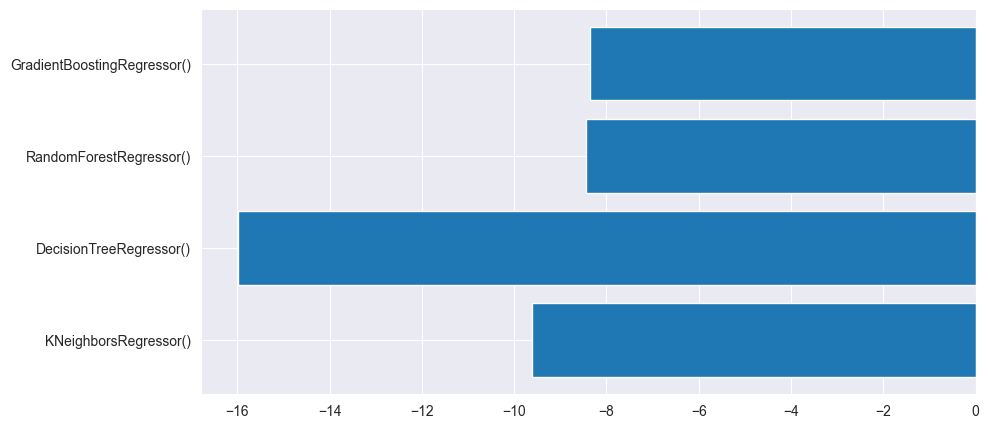

In [18]:
regressors = [
    KNeighborsRegressor(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(), 
    GradientBoostingRegressor()
]

models = []
scores = []

for regressor in regressors:
    steps = [
        ('preprocess', preprocessor),
        ('reg', regressor)
    ]
    pipeline = Pipeline(steps)
    scorer = cross_val_score(
        pipeline, 
        X_train, 
        y_train, 
        cv=5,
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    models.append(str(regressor))
    scores.append(scorer.mean())

plt.figure(figsize=(10,5))
plt.barh(models, scores)
plt.show();

In [19]:
le = LabelEncoder()

As we can see `GradientBoostingRegressor` has lowest MSE. Now it's time to tune it. We will be tuning in two steps, starting with `RandomSearchCV` and then getting best parameters possible with `GridSearchCV`.

In [20]:
loss = ['quantile', 'squared_error', 'absolute_error', 'huber']
max_features = ['sqrt', 'log2', None]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]

hyperparameter_grid = {
    'reg__loss': loss,
    'reg__max_features': max_features,
    'reg__n_estimators': n_estimators,
    'reg__max_depth': max_depth,
    'reg__min_samples_split': min_samples_split,
    'reg__min_samples_leaf': min_samples_leaf
}

random_cv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=hyperparameter_grid,
    cv=3,
    n_iter=200,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=state
)

random_cv.fit(X_train, y_train)

print()
print('Best params:')
print(random_cv.best_params_)
print()
print('Best score:', random_cv.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits

Best params:
{'reg__n_estimators': 50, 'reg__min_samples_split': 29, 'reg__min_samples_leaf': 22, 'reg__max_features': 'log2', 'reg__max_depth': 2, 'reg__loss': 'squared_error'}

Best score: -8.150200001630644


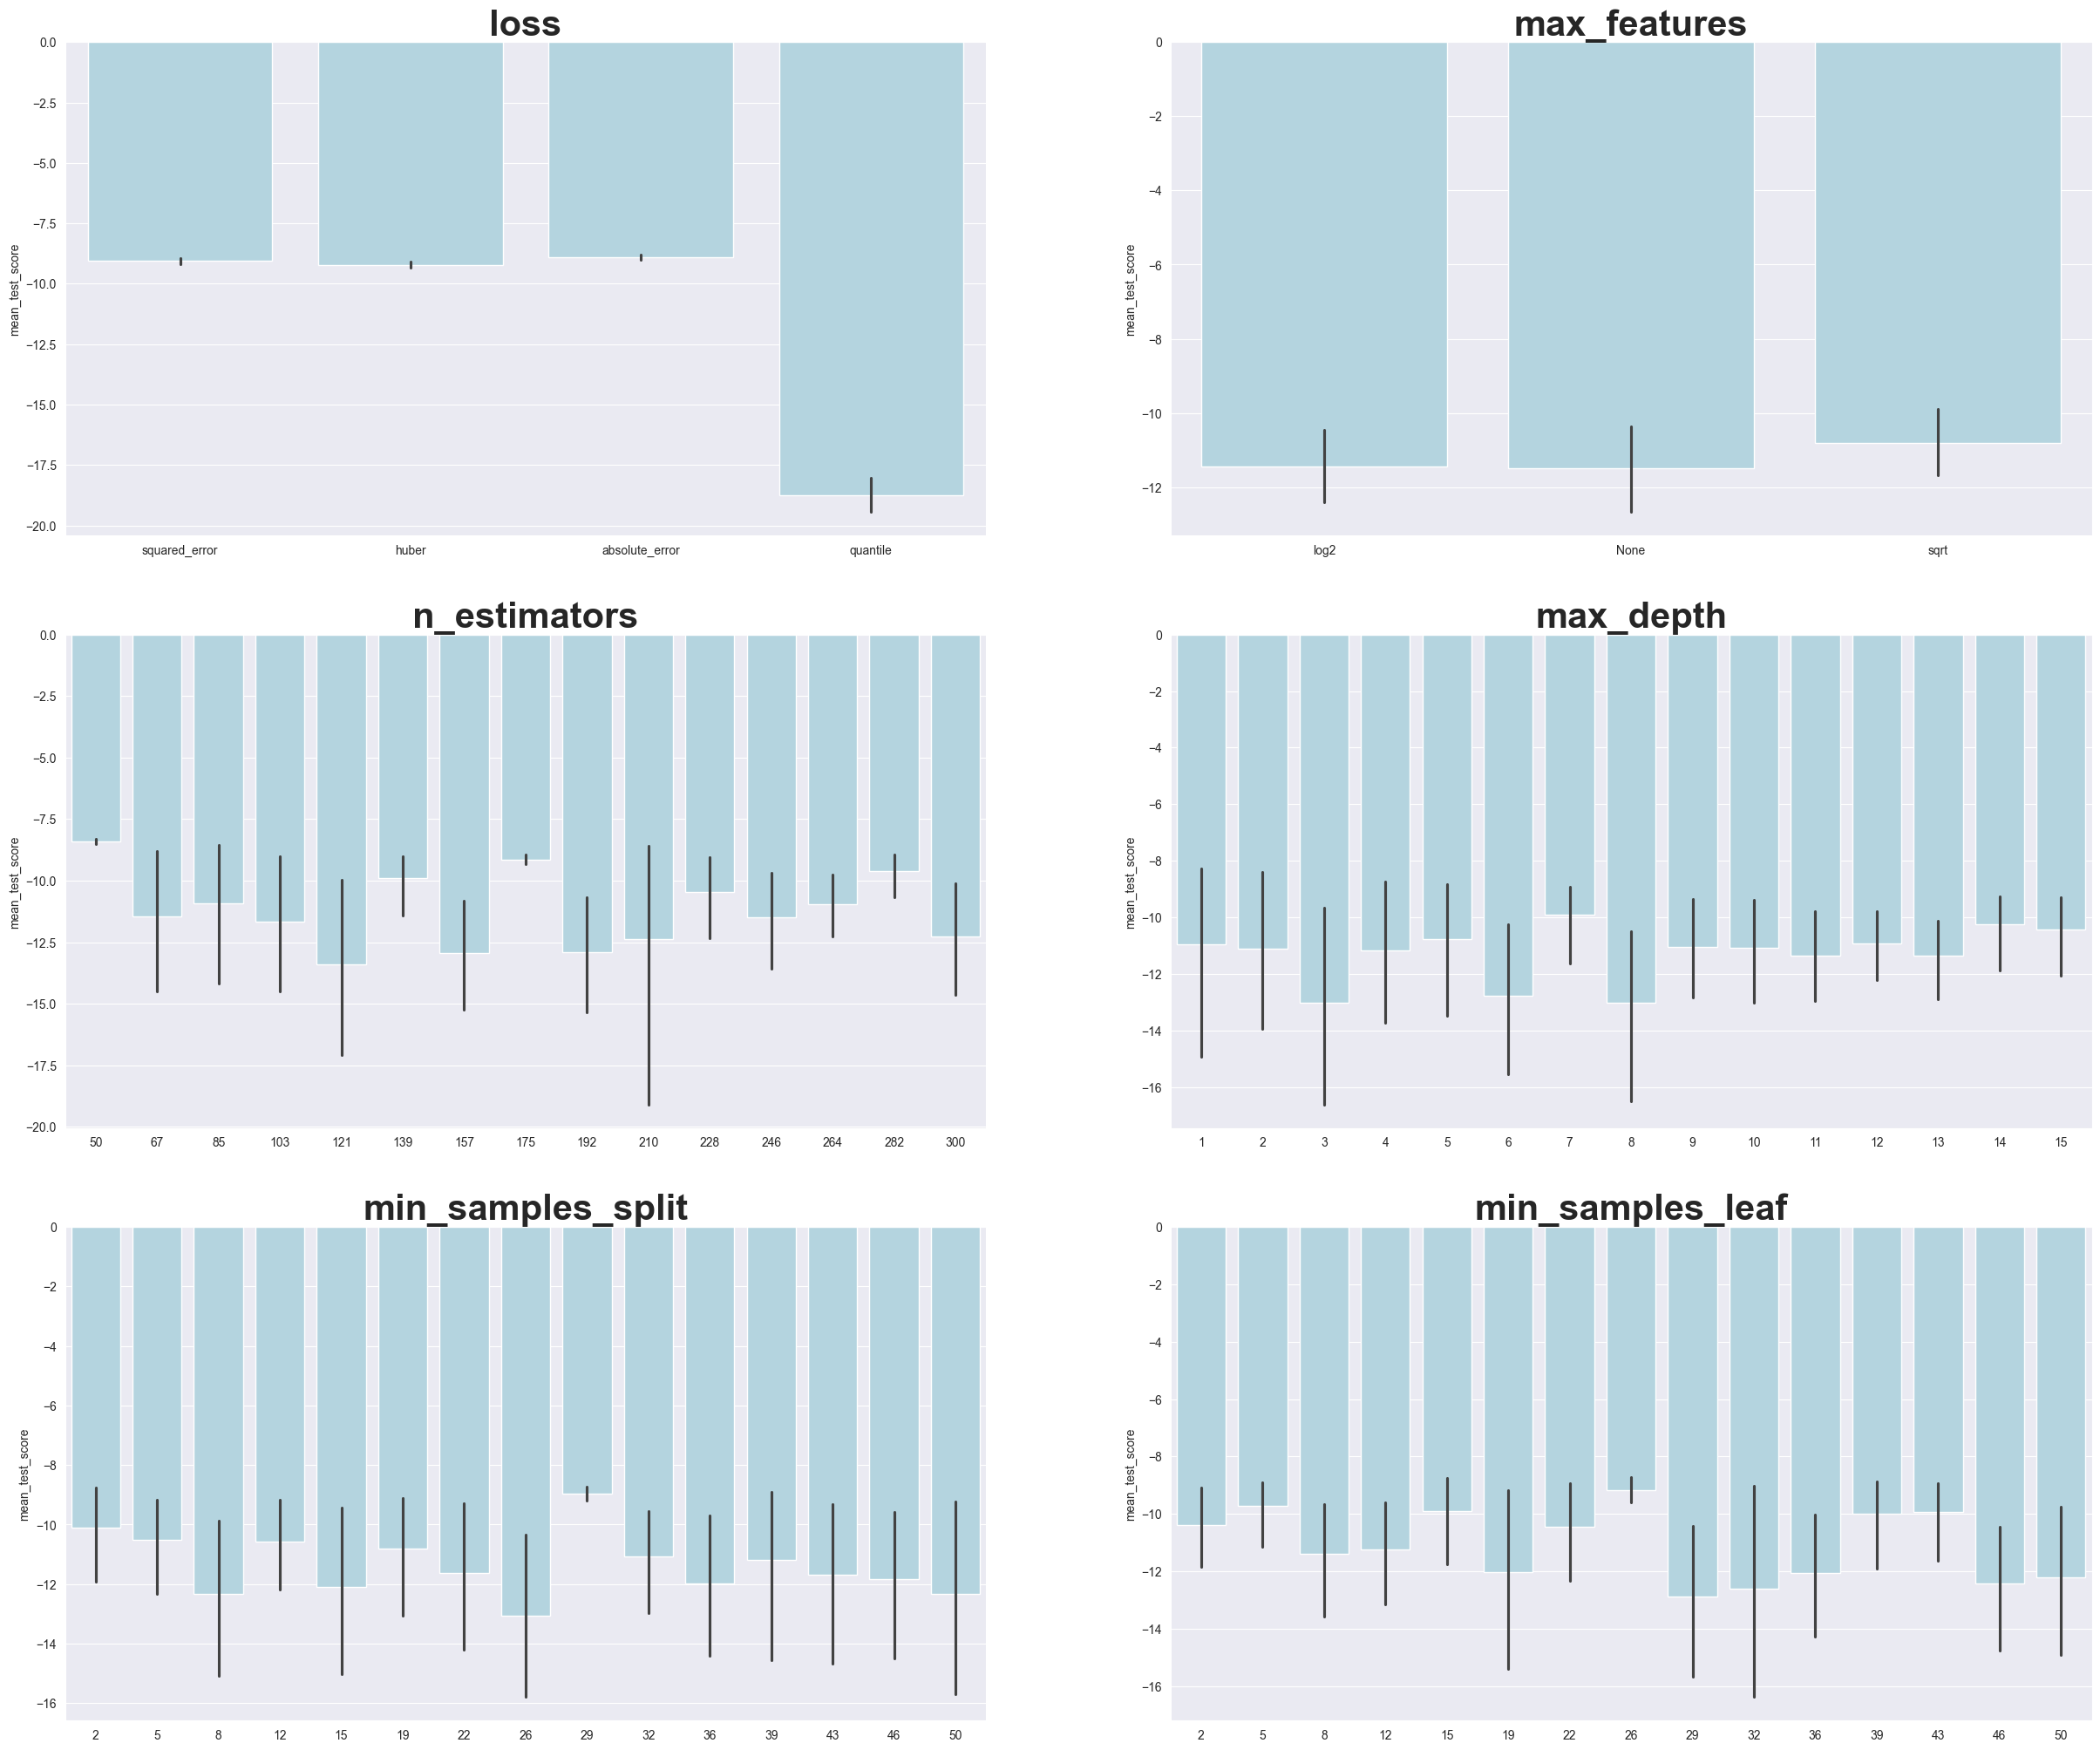

In [21]:
rs_df = pd.DataFrame(random_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.loc[rs_df['param_reg__max_features'].isna(), 'param_reg__max_features'] = 'None'

cols = [
    'param_reg__loss', 
    'param_reg__max_features',
    'param_reg__n_estimators',
    'param_reg__max_depth',
    'param_reg__min_samples_split',
    'param_reg__min_samples_leaf'
]
pref = 'param_reg__'

fig, axs = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(30,25)
sns.set(font_scale=2)
color = 'lightblue'
i = 0
j = 0

for col in cols:
    sns.barplot(
        x=col,
        y='mean_test_score', 
        data=rs_df, 
        ax=axs[i,j], 
        color=color
    )
    axs[i,j].set_title(
        label=col.replace(pref, ''), 
        size=30, 
        weight='bold'
    )
    axs[i,j].set_xlabel('')
    j += 1
    if j == 2:
        i += 1
        j = 0

Graphs show us no good reason to go for upper values in hyperparameters. Let's continue with `GridSearchCV`:

In [22]:
loss = ['absolute_error']
max_features = ['log2', None]
n_estimators = range(45, 55)
max_depth = range(1, 6)
min_samples_split = range(2, 9, 2)
min_samples_leaf = range(2, 9, 2)

hyperparameter_grid = {
    'reg__loss': loss,
    'reg__max_features': max_features,
    'reg__n_estimators': n_estimators,
    'reg__max_depth': max_depth,
    'reg__min_samples_split': min_samples_split,
    'reg__min_samples_leaf': min_samples_leaf
}

grid_cv = GridSearchCV(
    estimator=pipeline,
    param_grid=hyperparameter_grid,
    cv=3, 
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_cv.fit(X_train, y_train)
best_params = grid_cv.best_params_

print()
print('Best params:')
print(best_params)
print()
print('Best score:', grid_cv.best_score_)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits

Best params:
{'reg__loss': 'absolute_error', 'reg__max_depth': 1, 'reg__max_features': 'log2', 'reg__min_samples_leaf': 6, 'reg__min_samples_split': 6, 'reg__n_estimators': 49}

Best score: -8.13514245080446


Let's finish by checking MSE score on test subset:

In [23]:
pipeline.set_params(**best_params)

pipeline.fit(X_train, y_train)
y_pred = np.round(pipeline.predict(X_test))
print(f'MSE for test subset: {mean_squared_error(y_test, y_pred)}')

MSE for test subset: 8.532131661442007


# Conclusion

As mentioned above gathering individual health data when working out at a gym is vital for monitoring progress, identifying potential health risks, personalizing training programs, fostering motivation and accountability, and contributing to research. It empowers individuals to make informed decisions about their fitness journey, enhances safety and effectiveness, and promotes overall well-being.

As in almost any other field, machine learning can play a significant role in analyzing and utilizing the gathered individual workout data from gyms. The following are some examples of possible applications of ML:

Personalized Recommendations: Machine learning algorithms can analyze an individual's health data, workout history, and goals to provide personalized recommendations for exercise routines, nutrition plans, and recovery strategies.

Predictive Analytics: By applying machine learning techniques to historical health data, algorithms can identify patterns and correlations that predict future outcomes.

Health Data Analysis: This analysis can help identify dynamic health deterioration and predict possible progressive diseases, suggest an individual to visit a doctor in time. It can also identify factors that contribute to successful outcomes, uncover hidden patterns, and inform evidence-based practices in exercise science and fitness training.

Risk Assessment and Health Management: By leveraging machine learning, gyms and fitness centers can develop risk assessment models to identify individuals at higher risk of certain health conditions or injuries before they get hurt.

Behavior Change and Motivation: Machine learning algorithms can analyze behavioral patterns, exercise adherence data, and motivational factors to personalize interventions aimed at promoting long-term behavior change.

In this notebook we tried to use Machine learning algorithms to analyze performance metrics to suggest exercise intensity to optimize performance gains.

In [24]:
print(models)

['KNeighborsRegressor()', 'DecisionTreeRegressor()', 'RandomForestRegressor()', 'GradientBoostingRegressor()']


In [25]:
print(scores)

[-9.612706630919396, -15.994650605288905, -8.44650627454202, -8.358759441294833]


In [26]:
# Save the model as a pickle file
joblib.dump(models[3], 'model.pkl')

# Later we can load back the pickled model with this code:
# model = joblib.load('model.pkl')

['model.pkl']

In [27]:
joblib.dump(le, 'label_encoder.pkl')

# Later we can load back the pickled LabelEncoder with this code:
# le = joblib.load('label_encoder.pkl')

['label_encoder.pkl']

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming that the model is already trained and is named as `grid_cv`
# And the training and validation data are `X_train`, `y_train`, `X_test`, `y_test`

# Predict on the training data
y_train_pred = grid_cv.predict(X_train)

# Calculate MSE and RMSE for the training data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = sqrt(mse_train)

# Predict on the validation data
y_test_pred = grid_cv.predict(X_test)

# Calculate MSE and RMSE for the validation data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = sqrt(mse_test)

print(f"Training MSE: {mse_train}, Training RMSE: {rmse_train}")
print(f"Validation MSE: {mse_test}, Validation RMSE: {rmse_test}")

Training MSE: 7.983441592794865, Training RMSE: 2.8254984680220345
Validation MSE: 8.451335198371824, Validation RMSE: 2.907118022779919


In [30]:
import matplotlib.pyplot as plt

# Assuming that the model is already trained and is named as `grid_cv`
# And the training and validation data are `X_train`, `y_train`, `X_test`, `y_test`

# Predict on the training data
y_train_pred = grid_cv.predict(X_train)

# Calculate R-squared for the training data
r2_train = r2_score(y_train, y_train_pred)

# Predict on the validation data
y_test_pred = grid_cv.predict(X_test)

# Calculate R-squared for the validation data
r2_test = r2_score(y_test, y_test_pred)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(['Training', 'Validation'], [r2_train, r2_test], color='skyblue')
plt.ylabel('R-squared')
plt.title('R-squared for Training and Validation Data')
plt.show()from sklearn.metrics import r2_score

# Assuming that the model is already trained and is named as `grid_cv`
# And the training and validation data are `X_train`, `y_train`, `X_test`, `y_test`

# Predict on the training data
y_train_pred = grid_cv.predict(X_train)

# Calculate R-squared for the training data
r2_train = r2_score(y_train, y_train_pred)

# Predict on the validation data
y_test_pred = grid_cv.predict(X_test)

# Calculate R-squared for the validation data
r2_test = r2_score(y_test, y_test_pred)

print(f"Training R-squared: {r2_train}")
print(f"Validation R-squared: {r2_test}")

Training R-squared: 0.010599606196159184
Validation R-squared: -0.025626623833473916


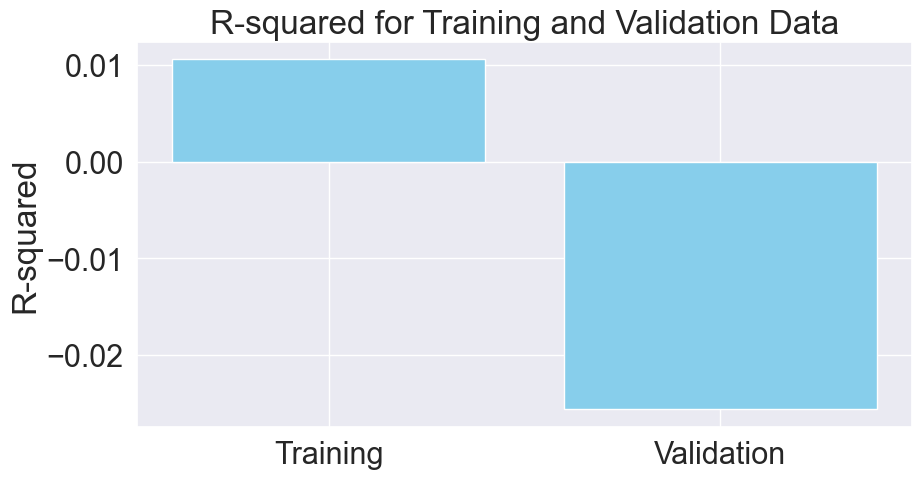

In [31]:
import matplotlib.pyplot as plt

# Assuming that the model is already trained and is named as `grid_cv`
# And the training and validation data are `X_train`, `y_train`, `X_test`, `y_test`

# Predict on the training data
y_train_pred = grid_cv.predict(X_train)

# Calculate R-squared for the training data
r2_train = r2_score(y_train, y_train_pred)

# Predict on the validation data
y_test_pred = grid_cv.predict(X_test)

# Calculate R-squared for the validation data
r2_test = r2_score(y_test, y_test_pred)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(['Training', 'Validation'], [r2_train, r2_test], color='skyblue')
plt.ylabel('R-squared')
plt.title('R-squared for Training and Validation Data')
plt.show()